## Just playing around with a random library my friend forked because our backend is currently going through a constitutional crisis.

https://github.com/CamDavidsonPilon/lifetimes

Immediate usecase for our company would be better understanding of our user interactions, better targetted marketing for instance. I'm going to run through their docs using sample data and see how it goes.

In [3]:
#imports
import pandas as pd
import numpy as np
import datetime
#oh shit here we go
import lifetimes
%matplotlib inline
import matplotlib.pyplot as plttouches
import os
import smtplib


In [14]:
import pandas.io.sql as psql
import psycopg2
connection = psycopg2.connect('your_tableinfo here')

In [62]:
df = pd.read_sql("SELECT user_id, order_id, transaction_id, date, amount_paid FROM your_table.orders;", connection)

In [64]:
df.head()

,user_id,order_id,transaction_id,date,amount_paid
0,e2b69dc1695ae4860a099fe8f80e30ff50249e01,36,1,02/05/2013 14:06:44 EST,3.0
1,b185c5696b2688da7855951fc3f6937287e9f0c6,8,10,02/11/2013 14:03:47 EST,3.0
2,69d2539d4bdbc0c007ac98de840315f33724d407,976,1000,07/19/2013 12:36:19 EST,3.49
3,9955ba52b27b341da6ca0f2f655f88799f2275c6,70819,100001,07/29/2015 19:49:50 EST,6.51
4,85483ad4b6a67e2502a21d9d0c275060881e8253,70821,100003,07/29/2015 19:50:01 EST,4.88


In [65]:
#apparently lifetimes will just convert this transactional data into their format, let's try it out
#from lifetimes.utils import summary_data_from_transaction_data
#summary_data_from_transaction_data(df, 'user_id', 'date')

In [66]:
#okay, I let it run for like 30 minutes and it didn't finish, so I'm just going to do this manually. 
#I'm also going to take out all the references to amount_paid because I don't want to go through the trouble of anonymizing that.

In [67]:
#convert date to datetime format, groupby order id 
df['amount_paid'] = pd.to_numeric(df['amount_paid'], errors='coerce')
df[['Created At 2', 'Created At 3', 'Created At 4']] = df['date'].str.split(expand = True)
df.drop(['date', 'Created At 3', 'Created At 4'],inplace=True,axis=1)
df.rename(index=str, columns={"Created At 2": "created_at"}, inplace = True)
df['created_at'] = pd.to_datetime(df['created_at'],format='%m/%d/%Y')

In [69]:
#so realistically we don't have transactions every day for a user, so I'm going to take every purchase date and just round to the first day of the month
df['created_at'] = df['created_at'].values.astype('datetime64[M]')

In [70]:
#grouping by orders instead of individual transactions
df2 = df.groupby(['user_id', 'created_at', 'order_id']).agg({"amount_paid":"sum"}).reset_index()


In [71]:
#refer back to our backend is going through a constitutional crisis
df3 = df2[df2['user_id']!='""']

In [145]:
df4 = df3.groupby('user_id').agg({"created_at":["min", "max", "nunique"], "amount_paid":"sum"}).reset_index()

In [146]:
#in case you didn't know, pandas occasionally creates two levels of columns and it looks like
df4.head()

user_id created_at                     \
                                                   min        max nunique   
0  000039a3c59f12c40491b889d403fde86f450452 2017-06-01 2017-06-01       1   
1  00003e836df40d3e3126cf476468000140506996 2017-10-01 2017-10-01       1   
2  000061a23ad301f65f0648cdaaa5f8a63459ebed 2017-05-01 2017-05-01       1   
3  0000716481cc966afee15059a96f69fbc15eb761 2015-09-01 2015-09-01       1   
4  000076c0a29d52a3d2797a2f12aea7224eec0b23 2017-09-01 2017-09-01       1   

  amount_paid  
          sum  
0        2.19  
1        8.15  
2        5.43  
3        5.00  
4       27.20

In [147]:
#good kids shouldn't do this, but it's a quick and dirty way to fix it... stack overflow 'multiindex pandas' for a better one
df4.columns = df4.columns.get_level_values(1)

In [148]:
df4.columns

Index(['', 'min', 'max', 'nunique', 'sum'], dtype='object')

In [149]:
df4.rename(index=str, columns={"": "user_id"}, inplace = True)

In [150]:
df4.head()

,user_id,min,max,nunique,sum
0,000039a3c59f12c40491b889d403fde86f450452,2017-06-01,2017-06-01,1,2.19
1,00003e836df40d3e3126cf476468000140506996,2017-10-01,2017-10-01,1,8.15
2,000061a23ad301f65f0648cdaaa5f8a63459ebed,2017-05-01,2017-05-01,1,5.43
3,0000716481cc966afee15059a96f69fbc15eb761,2015-09-01,2015-09-01,1,5.00
4,000076c0a29d52a3d2797a2f12aea7224eec0b23,2017-09-01,2017-09-01,1,27.20


In [151]:
#if you read through the quick start, the things we need are a user id, the age of the user, and the frequency, so now I'm making the last 2
df4['T'] = (datetime.date.today()-df4['min']).dt.days//30
df4['recency'] = (df4['max']-df4['min']).dt.days//30
df4['frequency'] = df4['nunique']-1

In [152]:
from lifetimes import BetaGeoFitter

# similar API to scikit-learn and lifelines.
bgf = BetaGeoFitter(penalizer_coef=0.0)
%timeit bgf.fit(df4['frequency'], df4['recency'], df4['T'])
print(bgf)

1 loop, best of 3: 1min 14s per loop
<lifetimes.BetaGeoFitter: fitted with 690870 subjects, a: 1.00, alpha: 7.00, b: 0.94, r: 0.11>


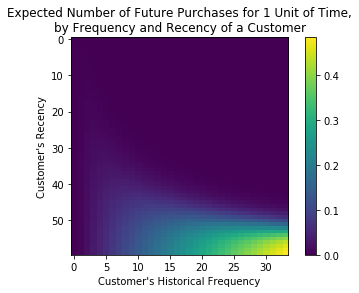

In [153]:
#okay, that's not terrible, 1 min for ~700k rows. 
from lifetimes.plotting import plot_frequency_recency_matrix

plot_frequency_recency_matrix(bgf)

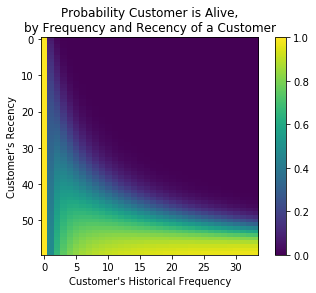

In [154]:
from lifetimes.plotting import plot_probability_alive_matrix

plot_probability_alive_matrix(bgf)

In [155]:
t = 1
df4['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, df4['nunique'], df4['recency'], df4['T'])
df4.sort_values(by='predicted_purchases').tail(5)

,user_id,min,max,nunique,sum,T,recency,frequency,predicted_purchases
578604,d6389aec2bff4bbd4b9e84c64a5b0b996ca708a2,2015-01-01,2017-12-01,30,2924.21,36,35,29,0.648473
490816,b5de6cf211c4e1768e1e38ec3d75f8aca536ad70,2015-02-01,2017-12-01,31,1857.43,35,34,30,0.685414
103160,2616258e9f77ca32acedc883e5d5ad130eff9d66,2015-02-01,2017-12-01,33,2540.22,35,34,32,0.730140
192145,46fedc39366d18884c462672b6cd420b194d5e48,2015-08-01,2017-12-01,29,12047.74,29,28,28,0.739889
320756,76c5400ea8c2f31998708fad52a7f216d79359b4,2015-04-01,2017-12-01,32,2079.77,33,32,31,0.740880


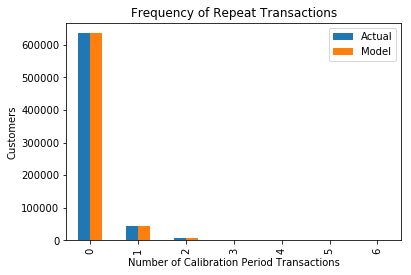

In [156]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [157]:
#yikes, this is some aggressive dropoff/overfitting... I really should just be subsampling but yolo
#I decided against using their methodology to convert my transactional data into an appropriate format, so I'm skipping the fitting section
#I'd just use sklearn split here I think

In [158]:
t = 10 #predict purchases in 10 periods
individual = df4.iloc[690865]
# The below function is an alias to `bfg.conditional_expected_number_of_purchases_up_to_time`
bgf.predict(t, individual['nunique'], individual['recency'], individual['T'])
# 0.0576511

0.32364104163293095

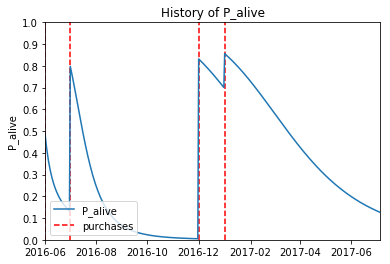

In [159]:
from lifetimes.plotting import plot_history_alive

id = 'ffff14f9153b0c7968b58e2a753bb9f4d2e1fb50'
days_since_birth = 400
sp_trans = df3.loc[df3['user_id'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'created_at')

In [160]:
#iiiiiiiinteresting. I'm like not totally sold on the quality of this model, but I also didn't clean my data at all so no judgment just yet

In [161]:
#k, so now I'm doing the model that accounts for amount spent
#small change, it is possible for transactions to end up with amount paid of 0 in our db due to refunds/rewards, they don't like that
#it's also possible that the 'monetary_value' in the documentation is the total amount spent not average spent
#yeah it is whoops, leaving the comments in there in case anyone else was confused
returning_customers = df4[(df4['frequency']>0) & (df4['sum']>0)]
returning_customers[['sum', 'frequency']].corr()

#interesting conversation on using gamma gamma to model first time customers, 
#https://github.com/CamDavidsonPilon/lifetimes/issues/135

,sum,frequency
sum,1.000000,0.367063
frequency,0.367063,1.000000


In [162]:
#well, it appears that we don't have a strong inverse correlation between sum and frequency, rip
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
%timeit ggf.fit(returning_customers['frequency'], returning_customers['sum'])
print(ggf)

1 loop, best of 3: 2min 31s per loop
<lifetimes.GammaGammaFitter: fitted with 55465 subjects, p: 766.26, q: 2.79, v: 0.08>


In [165]:
#2.5min for ~60k...
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        df4['frequency'],
        df4['sum']
    ).mean(),
    df4[df4['frequency']>0]['sum'].mean()
))

Expected conditional average profit: 32.67470687578905, Average profit: 34.96151492752536
